<a href="https://colab.research.google.com/github/pe44enka/HousePriceChallendge/blob/master/HousePriceChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from vega_datasets import  data

import statsmodels.api as sm

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [4]:
df =  pd.read_csv('https://raw.githubusercontent.com/pe44enka/HousePriceChallendge/master/data/Housing.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data Preprocessing

### Data for LR

####Missing Data

In [ ]:
df[df.columns[df.isna().sum().values > 0]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [ ]:
#drop categorical columns with about 50% of missing values & constant features (like id)
df.drop(columns=['Id', 'Alley', 'FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], inplace=True)

#fill na of numerical columns with mean of the  particular column
df['LotFrontage'] = df.LotFrontage.fillna(df.LotFrontage.mean())
df['GarageYrBlt'] = df.GarageYrBlt.fillna(int(df.GarageYrBlt.mean())).astype(int)
df['MasVnrArea'] = df.MasVnrArea.fillna(int(df.MasVnrArea.mean())).astype(int)

#drop others missing values in categorical columns
df.dropna(inplace=True)

df.shape

(1338, 75)

In [ ]:
#check for NaN
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y = df.pop('SalePrice')
X = df
X = X.reset_index()
X.pop('index')
print(X.shape)
X.head()

(1338, 74)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


#### Categorical Data

In [ ]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
print(len(cat_cols))
cat_cols

38


['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
X[cat_cols].nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      14
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         4
Foundation        5
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [ ]:
single_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()==1).values].tolist()
len(single_value_cols)

0

In [ ]:
multi_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()>1).values].tolist()
len(multi_value_cols)

38

In [ ]:
#get dummies on multiple cols categorical features
X = pd.get_dummies(X, columns=multi_value_cols, drop_first=True)
print(X.shape)
X.head()

(1338, 227)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2,2008,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,5,2007,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,9,2008,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2,2006,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,12,2008,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


#### Standartization



---

**Warning:** no standartization for RandomForest and GradientBoostingMachine

---



In [ ]:
num_cols = X.columns[X.dtypes!='uint8'].tolist()
print(len(num_cols))
num_cols

36


['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [ ]:
#standartize data
std = StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X[num_cols]), columns=num_cols)
print(X_std.shape)
X_std.head()

(1338, 36)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.296255,-0.983421,-0.591875,-0.828516,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,0.915080,-1.005546,0.985427,0.202747,0.249341,-0.779554,0.202294,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,0.146084
1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,0.409598,0.221935,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,-0.799291,0.174239,-0.17119,-0.347165,0.544478,-0.104844,0.202747,-0.222023,1.557895,-0.731311,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561,-0.605686
2,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.296255,-0.337652,-0.434007,-0.662928,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,-0.347165,0.544478,0.904666,0.202747,0.570726,-0.779554,-0.088501,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.988784,0.146084
3,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.296255,-0.096626,-0.838543,-0.556848,0.906167,-0.10374,0.344773,1.088949,-0.250577,-1.051375,-0.799291,0.174239,-0.17119,0.283958,0.544478,0.783525,1.779928,0.752844,-0.779554,-0.195636,4.122511,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,-1.357457
4,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.296255,-0.210318,0.120996,-0.080781,1.580921,-0.10374,1.269088,1.088949,-0.250577,0.775560,1.184848,1.462256,-0.17119,1.546203,0.544478,0.864286,1.779928,1.791989,0.726453,0.554309,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,2.100542,0.146084


In [ ]:
X = X.drop(columns=num_cols)
X = X.merge(X_std, left_index=True, right_index=True, how='left')
print(X.shape)
X.head()

(1338, 227)


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.296255,-0.983421,-0.591875,-0.828516,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,0.915080,-1.005546,0.985427,0.202747,0.249341,-0.779554,0.202294,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,0.146084
1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,0.409598,0.221935,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,-0.799291,0.174239,-0.17119,-0.347165,0.544478,-0.104844,0.202747,-0.222023,1.557895,-0.731311,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561,-0.605686
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.296255,-0.337652,-0.434007,-0.662928,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,-0.347165,0.544478,0.904666,0.202747,0.570726,-0.779554,-0.088501,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.988784,0.146084
3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.296255,-0.096626,-0.838543,-0.556848,0.906167,-0.10374,0.344773,1.088949,-0.250577,-1.051375,-0.799291,0.174239,-0.17119,0.283958,0.544478,0.783525,1.779928,0.752844,-0.779554,-0.195636,4.122511,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,-1.357457
4,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.296255,-0.210318,0.120996,-0.080781,1.580921,-0.10374,1.269088,1.088949,-0.250577,0.775560,1.184848,1.462256,-0.17119,1.546203,0.544478,0.864286,1.779928,1.791989,0.726453,0.554309,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,2.100542,0.146084


#### Feature Selection: Lasso Regression

In [ ]:
gs = GridSearchCV(estimator=Lasso(random_state=0), param_grid={'alpha':list(range(100, 1001, 50))}, cv=10)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098685,0.009077,0.002649,0.000182,100,{'alpha': 100},0.908939,0.907172,0.904345,0.769465,0.880792,0.831490,0.877844,0.858652,0.417339,0.879121,0.823516,0.141192,5
1,0.063029,0.005541,0.002664,0.000349,150,{'alpha': 150},0.905526,0.907595,0.908158,0.769011,0.869502,0.854573,0.877320,0.862388,0.412388,0.881597,0.824806,0.142758,3
2,0.047671,0.002661,0.002561,0.000047,200,{'alpha': 200},0.905158,0.905785,0.910459,0.766014,0.862245,0.868495,0.875796,0.866002,0.413778,0.884317,0.825805,0.142790,1
3,0.039528,0.002712,0.002581,0.000038,250,{'alpha': 250},0.903839,0.901911,0.911812,0.762000,0.858660,0.872576,0.876111,0.869159,0.414978,0.884983,0.825603,0.142586,2
4,0.035817,0.003643,0.002573,0.000064,300,{'alpha': 300},0.900784,0.898597,0.912772,0.757610,0.855636,0.870078,0.876067,0.870946,0.416163,0.885058,0.824371,0.142072,4
5,0.029935,0.001674,0.002668,0.000412,350,{'alpha': 350},0.899831,0.896789,0.912860,0.753982,0.852125,0.867605,0.875312,0.870355,0.416201,0.884464,0.822952,0.141868,6
6,0.028758,0.003266,0.002586,0.000102,400,{'alpha': 400},0.898645,0.894712,0.912235,0.751968,0.848407,0.864823,0.874476,0.868263,0.407209,0.883842,0.820458,0.144044,7
7,0.025186,0.002068,0.002569,0.000041,450,{'alpha': 450},0.897092,0.892368,0.911102,0.749765,0.844465,0.861747,0.873207,0.865520,0.398560,0.882955,0.817678,0.146006,8
8,0.024768,0.002174,0.002573,0.000055,500,{'alpha': 500},0.894937,0.890079,0.909821,0.747470,0.840497,0.858286,0.872181,0.861884,0.390619,0.881301,0.814708,0.147670,9
9,0.022810,0.001377,0.002540,0.000036,550,{'alpha': 550},0.892350,0.887455,0.908685,0.745469,0.836289,0.854961,0.871107,0.857871,0.384039,0.879632,0.811786,0.148890,10


In [ ]:
print('Best score: ', gs.best_score_, '\nBest parameter: ', gs.best_params_)

Best score:  0.8258047792030409 
Best parameter:  {'alpha': 200}


In [ ]:
#feature selection by L1 regularization
sfm_model = SelectFromModel(gs.best_estimator_)
sfm_model.fit(X, y)
X = X.loc[:, X.columns[sfm_model.get_support()]]
#X_test = X_test.loc[:, X_test.columns[sfm_model.get_support()]]
print(X.shape)
X.head()

(1338, 86)


,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,...,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,0.174239,-0.17119,0.915080,-1.005546,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1,0,1,0,1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,0.174239,-0.17119,-0.347165,0.544478,0.202747,1.557895,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,0.174239,-0.17119,-0.347165,0.544478,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,0.988784
3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,0.906167,-0.10374,0.344773,1.088949,-0.250577,-1.051375,0.174239,-0.17119,0.283958,0.544478,1.779928,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
4,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,1.580921,-0.10374,1.269088,1.088949,-0.250577,0.775560,1.462256,-0.17119,1.546203,0.544478,1.779928,0.726453,-0.118688,-0.283203,-0.071771,-0.084535,2.100542


#### Multicollinearity

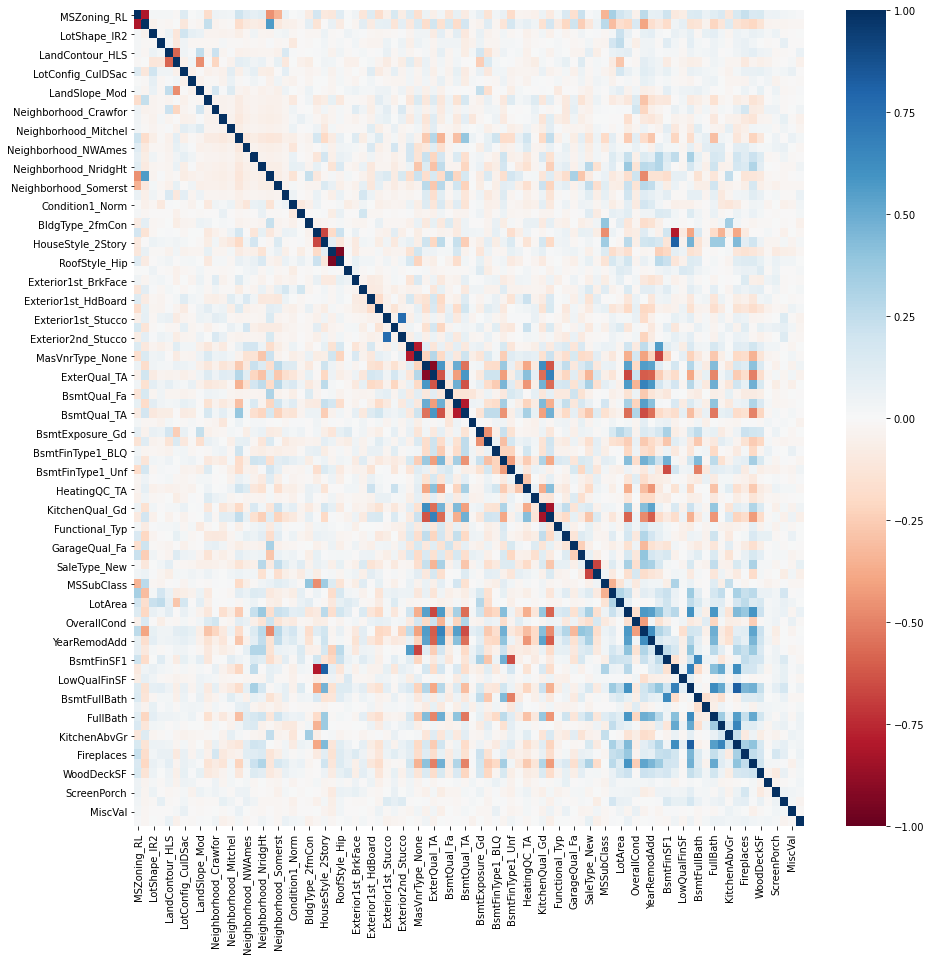

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='RdBu', vmax=1, vmin=-1)

In [ ]:
corr_matrix = X.corr()
columns = corr_matrix.columns

corr_matrix.reset_index(inplace=True)
corr_matrix = corr_matrix.melt(id_vars='index', value_vars=columns)
print(corr_matrix.shape)
corr_matrix.head()

(7396, 3)


,index,variable,value
0,MSZoning_RL,MSZoning_RL,1.000000
1,MSZoning_RM,MSZoning_RL,-0.807847
2,LotShape_IR2,MSZoning_RL,0.023244
3,LotShape_IR3,MSZoning_RL,0.022271
4,LandContour_HLS,MSZoning_RL,0.017553


In [ ]:
corr_matrix = corr_matrix[corr_matrix.value!=1]
cols_to_drop = corr_matrix[corr_matrix.value > .8]['index'].tolist()
X = X.drop(columns=cols_to_drop)
print(X.shape)
X.head()

(1338, 82)


,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,...,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,...,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.10374,1.088949,-0.250577,0.775560,0.174239,-0.17119,-1.005546,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.10374,-0.851149,3.888586,0.775560,0.174239,-0.17119,0.544478,0.202747,1.557895,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.10374,1.088949,-0.250577,0.775560,0.174239,-0.17119,0.544478,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,0.988784
3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.10374,1.088949,-0.250577,-1.051375,0.174239,-0.17119,0.544478,1.779928,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
4,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.10374,1.088949,-0.250577,0.775560,1.462256,-0.17119,0.544478,1.779928,0.726453,-0.118688,-0.283203,-0.071771,-0.084535,2.100542


#### train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape, X_test.shape)

(1003, 82) (335, 82)


### Data for RF & GBM

####Missing Data

In [ ]:
df[df.columns[df.isna().sum().values > 0]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [ ]:
#drop categorical columns with about 50% of missing values & constant features (like id)
df.drop(columns=['Id', 'Alley', 'FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], inplace=True)

#fill na of numerical columns with mean of the  particular column
df['LotFrontage'] = df.LotFrontage.fillna(df.LotFrontage.mean())
df['GarageYrBlt'] = df.GarageYrBlt.fillna(int(df.GarageYrBlt.mean())).astype(int)
df['MasVnrArea'] = df.MasVnrArea.fillna(int(df.MasVnrArea.mean())).astype(int)

#drop others missing values in categorical columns
df.dropna(inplace=True)

df.shape

(1338, 75)

In [ ]:
#check for NaN
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y = df.pop('SalePrice')
X = df
X = X.reset_index()
X.pop('index')
print(X.shape)
X.head()

(1338, 74)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


#### Categorical Data

In [ ]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
print(len(cat_cols))
cat_cols

38


['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
X[cat_cols].nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      14
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         4
Foundation        5
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [ ]:
single_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()==1).values].tolist()
len(single_value_cols)

0

In [ ]:
multi_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()>1).values].tolist()
len(multi_value_cols)

38

In [ ]:
#get dummies on multiple cols categorical features
X = pd.get_dummies(X, columns=multi_value_cols, drop_first=False)
print(X.shape)
X.head()

(1338, 265)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2,2008,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,5,2007,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,9,2008,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2,2006,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,12,2008,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


#### Feature Selection: Random Forest

In [ ]:
gs = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True), param_grid={'max_depth':list(range(1, 21,))}, cv=10)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.348395,0.007595,0.009715,0.001242,1,{'max_depth': 1},0.363816,0.464915,0.490598,0.493360,0.536089,0.464446,0.476106,0.444693,0.448731,0.460020,0.464277,0.041919,20
1,0.501127,0.006800,0.010412,0.002138,2,{'max_depth': 2},0.598238,0.669834,0.729251,0.642800,0.697427,0.634646,0.659448,0.667964,0.628453,0.681106,0.660917,0.035415,19
2,0.654977,0.004633,0.009507,0.000616,3,{'max_depth': 3},0.714092,0.748693,0.819349,0.705385,0.780276,0.738207,0.746933,0.780983,0.673670,0.762782,0.747037,0.040022,18
3,0.823210,0.003149,0.009752,0.000162,4,{'max_depth': 4},0.772669,0.812381,0.873060,0.743742,0.822295,0.805745,0.793798,0.839054,0.720481,0.803271,0.798650,0.042205,17
4,0.994553,0.007371,0.009773,0.000158,5,{'max_depth': 5},0.813036,0.835335,0.889757,0.750207,0.848308,0.836989,0.834994,0.857852,0.735352,0.830676,0.823251,0.044657,16
5,1.177817,0.004450,0.010171,0.000199,6,{'max_depth': 6},0.820084,0.852591,0.904249,0.737854,0.861483,0.863632,0.866884,0.879402,0.777894,0.849035,0.841311,0.047259,15
6,1.375772,0.007643,0.010319,0.000177,7,{'max_depth': 7},0.844025,0.863396,0.907082,0.747267,0.864586,0.873231,0.868533,0.890933,0.728921,0.858734,0.844671,0.055903,14
7,1.582672,0.005525,0.010731,0.000224,8,{'max_depth': 8},0.849381,0.870294,0.912143,0.760489,0.873654,0.878283,0.870968,0.892972,0.725914,0.858678,0.849278,0.056035,13
8,1.785254,0.007553,0.011232,0.000816,9,{'max_depth': 9},0.843591,0.862403,0.910049,0.756316,0.869762,0.866100,0.886418,0.901191,0.790421,0.861288,0.854754,0.045415,9
9,1.981203,0.010628,0.011731,0.001260,10,{'max_depth': 10},0.853211,0.867875,0.910466,0.759404,0.874641,0.879249,0.884609,0.895955,0.752116,0.859025,0.853655,0.051473,12


In [ ]:
print('Best score: ', gs.best_score_, '\nBest parameter: ', gs.best_params_)

Best score:  0.8584246869060669 
Best parameter:  {'max_depth': 12}


In [ ]:
#feature selection by L1 regularization
sfm_model = SelectFromModel(gs.best_estimator_)
sfm_model.fit(X, y)
X = X.loc[:, X.columns[sfm_model.get_support()]]
#X_test = X_test.loc[:, X_test.columns[sfm_model.get_support()]]
print(X.shape)
X.head()

(1338, 20)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold
0,65.0,8450,7,5,2003,2003,706,150,856,856,854,1710,2,8,2003,2,548,0,61,2
1,80.0,9600,6,8,1976,1976,978,284,1262,1262,0,1262,2,6,1976,2,460,298,0,5
2,68.0,11250,7,5,2001,2002,486,434,920,920,866,1786,2,6,2001,2,608,0,42,9
3,60.0,9550,7,5,1915,1970,216,540,756,961,756,1717,1,7,1998,3,642,0,35,2
4,84.0,14260,8,5,2000,2000,655,490,1145,1145,1053,2198,2,9,2000,3,836,192,84,12


#### Multicollinearity

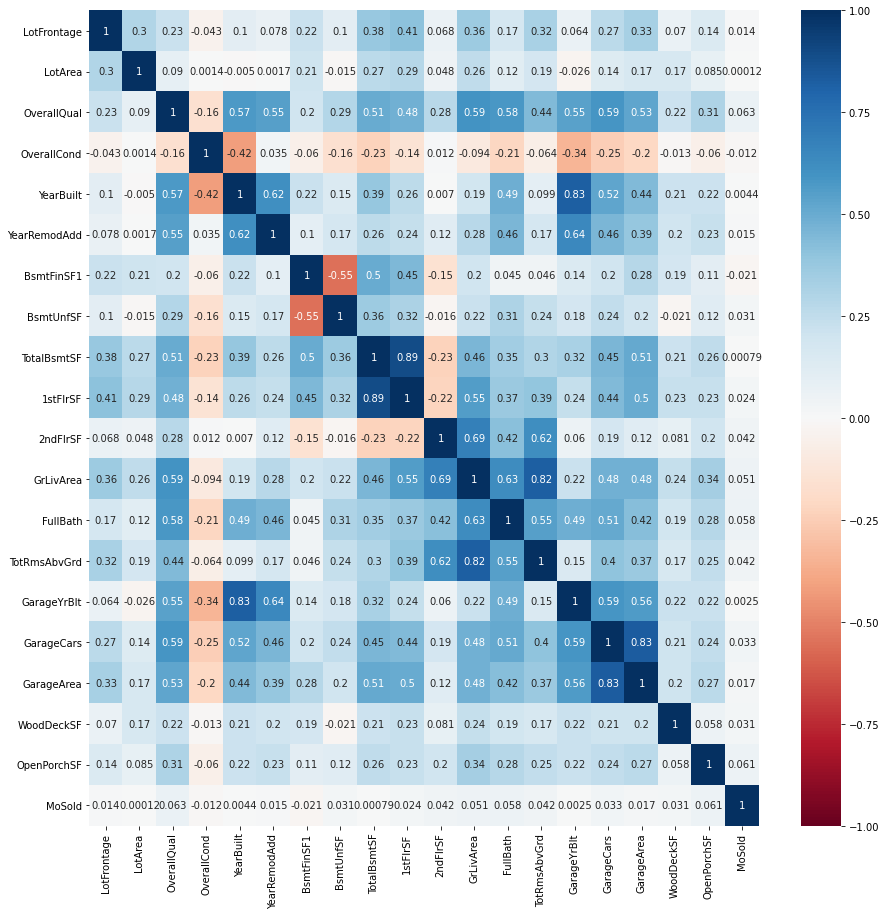

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='RdBu', vmax=1, vmin=-1, annot=True)

In [ ]:
corr_matrix = X.corr()
columns = corr_matrix.columns

corr_matrix.reset_index(inplace=True)
corr_matrix = corr_matrix.melt(id_vars='index', value_vars=columns)
print(corr_matrix.shape)
corr_matrix.head()

(400, 3)


,index,variable,value
0,LotFrontage,LotFrontage,1.000000
1,LotArea,LotFrontage,0.300018
2,OverallQual,LotFrontage,0.225559
3,OverallCond,LotFrontage,-0.042652
4,YearBuilt,LotFrontage,0.102425


In [ ]:
corr_matrix = corr_matrix[corr_matrix.value!=1]
cols_to_drop = corr_matrix[corr_matrix.value > .8]['index'].tolist()
X = X.drop(columns=cols_to_drop)
print(X.shape)
X.head()

(1338, 12)


,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,2ndFlrSF,FullBath,WoodDeckSF,OpenPorchSF,MoSold
0,65.0,8450,7,5,2003,706,150,854,2,0,61,2
1,80.0,9600,6,8,1976,978,284,0,2,298,0,5
2,68.0,11250,7,5,2002,486,434,866,2,0,42,9
3,60.0,9550,7,5,1970,216,540,756,1,0,35,2
4,84.0,14260,8,5,2000,655,490,1053,2,192,84,12


#### train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape, X_test.shape)

(1003, 12) (335, 12)


## LinearRegression

### statsmodel

In [ ]:
#LR model
Y_train_sm = list(Y_train)
X_train_sm = sm.add_constant(X_train)
lr_model = sm.OLS(Y_train_sm, X_train_sm)
result = lr_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     89.06
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:22:18   Log-Likelihood:                -11635.
No. Observations:                1003   AIC:                         2.344e+04
Df Residuals:                     920   BIC:                         2.384e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.115e+05 

### LinearRegression Model and Evaluation

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr.score(X_test, Y_test)

0.7116413789459229

## Random Forest

In [ ]:
rf_gs = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True), param_grid={'max_depth':list(range(1, 21,))}, cv=10)
rf_gs.fit(X_train, Y_train)
pd.DataFrame(rf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.193510,0.009040,0.008741,0.000227,1,{'max_depth': 1},0.322609,0.451674,0.482073,0.469671,0.525759,0.626163,0.409634,0.428585,0.313119,0.600634,0.462992,0.098105,20
1,0.218961,0.003511,0.008666,0.000236,2,{'max_depth': 2},0.542859,0.590601,0.652426,0.614329,0.689501,0.700516,0.596762,0.676993,0.492458,0.722671,0.627912,0.070130,19
2,0.247635,0.003273,0.009069,0.000374,3,{'max_depth': 3},0.693162,0.707015,0.722344,0.705385,0.773662,0.757536,0.652399,0.763668,0.503620,0.783974,0.706276,0.078040,18
3,0.275785,0.003489,0.009410,0.000779,4,{'max_depth': 4},0.757887,0.752840,0.759749,0.756613,0.826477,0.781275,0.708006,0.802583,0.474489,0.830652,0.745057,0.096815,17
4,0.303221,0.003418,0.009184,0.000161,5,{'max_depth': 5},0.790549,0.772882,0.790359,0.789023,0.848066,0.810695,0.732956,0.837499,0.467579,0.851092,0.769070,0.106260,16
5,0.333163,0.004392,0.009308,0.000209,6,{'max_depth': 6},0.790268,0.793592,0.796102,0.804519,0.857571,0.826498,0.752135,0.857339,0.501222,0.867699,0.784695,0.100636,14
6,0.360218,0.004234,0.009789,0.000887,7,{'max_depth': 7},0.793524,0.799299,0.797329,0.807716,0.855020,0.832300,0.764364,0.862766,0.448202,0.879188,0.783971,0.116984,15
7,0.389137,0.002702,0.009951,0.000479,8,{'max_depth': 8},0.810221,0.804244,0.802919,0.827630,0.859017,0.830332,0.763374,0.876348,0.501610,0.879839,0.795554,0.103770,8
8,0.415441,0.002768,0.010005,0.000233,9,{'max_depth': 9},0.814221,0.794593,0.812275,0.827707,0.853546,0.835258,0.786933,0.877514,0.487371,0.886732,0.797615,0.108001,2
9,0.442479,0.003066,0.010279,0.000121,10,{'max_depth': 10},0.799390,0.811054,0.804448,0.824015,0.852545,0.836956,0.779720,0.873776,0.498566,0.877222,0.795769,0.103608,5


In [ ]:
print('Best score: ', rf_gs.best_score_, '\nBest parameter: ', rf_gs.best_params_)

Best score:  0.7990153117068203 
Best parameter:  {'max_depth': 14}


In [ ]:
rfr = rf_gs.best_estimator_
rfr.fit(X_train, Y_train)
print('Accuracy of training set: ', rfr.score(X_train, Y_train))
print('Accuracy of test set: ', rfr.score(X_test, Y_test))

Accuracy of training set:  0.9734610287049261
Accuracy of test set:  0.7793002391000122


## Gradient Boosting Machine

In [ ]:
gbm_gs = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0), param_grid={'max_depth' : list(range(1,20))+[None], 'learning_rate':list(np.arange(0.01, 1, 0.1))}, cv=10)
gbm_gs.fit(X_train, Y_train)
pd.DataFrame(gbm_gs.cv_results_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'NoneType' and 'float'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'NoneType' and 'float'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'NoneType' and 'float'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.p

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.085642,0.004906,0.001839,0.000156,0.01,1,"{'learning_rate': 0.01, 'max_depth': 1}",0.303686,0.475570,0.440852,0.520310,0.484794,0.478679,0.428827,0.378838,0.429692,0.494052,0.443530,0.060472,200
1,0.133352,0.005483,0.002030,0.000376,0.01,2,"{'learning_rate': 0.01, 'max_depth': 2}",0.454992,0.570813,0.541771,0.608662,0.590440,0.567018,0.530261,0.611093,0.524531,0.574051,0.557363,0.044385,199
2,0.176106,0.001534,0.001926,0.000056,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",0.557520,0.620966,0.575197,0.663520,0.650161,0.605214,0.584507,0.686108,0.565196,0.626822,0.613521,0.041466,198
3,0.223292,0.003883,0.002008,0.000048,0.01,4,"{'learning_rate': 0.01, 'max_depth': 4}",0.611691,0.645927,0.621184,0.698280,0.685500,0.633493,0.619848,0.726501,0.517205,0.670550,0.643018,0.055235,185
4,0.268499,0.005900,0.002109,0.000032,0.01,5,"{'learning_rate': 0.01, 'max_depth': 5}",0.643623,0.667145,0.646766,0.709253,0.696094,0.672932,0.642699,0.757320,0.529902,0.697302,0.666304,0.056640,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.002344,0.000122,0.000000,0.000000,None,16,"{'learning_rate': None, 'max_depth': 16}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204
216,0.002305,0.000028,0.000000,0.000000,None,17,"{'learning_rate': None, 'max_depth': 17}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
217,0.002293,0.000017,0.000000,0.000000,None,18,"{'learning_rate': None, 'max_depth': 18}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202
218,0.002376,0.000137,0.000000,0.000000,None,19,"{'learning_rate': None, 'max_depth': 19}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219


In [ ]:
print('Best score: ', gbm_gs.best_score_, '\nBest parameter: ', gbm_gs.best_params_)

Best score:  0.8009351946476475 
Best parameter:  {'learning_rate': 0.11, 'max_depth': 3}


In [ ]:
gbm = gbm_gs.best_estimator_
gbm.fit(X_train, Y_train)
print('Accuracy of training set: ', gbm.score(X_train, Y_train))
print('Accuracy of test set: ', gbm.score(X_test, Y_test))

Accuracy of training set:  0.9492052822234339
Accuracy of test set:  0.7383460611302113


## XGBoost

In [ ]:
xgb_gs = GridSearchCV(estimator=XGBRegressor(), param_grid={'max_depth':list(range(1,20))+[None], 'learning_rate':list(np.arange(0.01, 1, 0.1))}, cv=10)
xgb_gs.fit(X_train, Y_train)
pd.DataFrame(xgb_gs.cv_results_)

[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:58:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036551,0.001328,0.002097,0.000356,0.01,1,"{'learning_rate': 0.01, 'max_depth': 1}",-0.238257,-0.332632,-0.491449,-0.661584,-0.500074,-0.221482,-0.294290,-0.364590,-0.691550,-0.163280,-0.395919,0.173974,190
1,0.052909,0.002831,0.002092,0.000165,0.01,2,"{'learning_rate': 0.01, 'max_depth': 2}",-0.113240,-0.252098,-0.367193,-0.592164,-0.428919,-0.125395,-0.217465,-0.232370,-0.626115,-0.090837,-0.304580,0.183148,189
2,0.067999,0.002452,0.002287,0.000343,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",-0.126616,-0.245888,-0.328879,-0.545209,-0.412123,-0.109321,-0.190552,-0.172860,-0.571329,-0.050584,-0.275336,0.173427,188
3,0.089577,0.003990,0.002183,0.000070,0.01,4,"{'learning_rate': 0.01, 'max_depth': 4}",-0.135871,-0.261996,-0.306096,-0.536770,-0.372901,-0.080819,-0.153503,-0.152140,-0.524448,0.004292,-0.252025,0.173526,173
4,0.107881,0.002156,0.002290,0.000119,0.01,5,"{'learning_rate': 0.01, 'max_depth': 5}",-0.134759,-0.260023,-0.283648,-0.533649,-0.368543,-0.088297,-0.150340,-0.163551,-0.514231,-0.010977,-0.250802,0.167188,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.324145,0.016878,0.003558,0.000378,0.91,16,"{'learning_rate': 0.91, 'max_depth': 16}",0.671992,0.585292,0.706325,0.639945,0.723323,0.682951,0.695677,0.757831,0.148887,0.600481,0.621270,0.165358,166
196,0.335642,0.019678,0.003596,0.000443,0.91,17,"{'learning_rate': 0.91, 'max_depth': 17}",0.680505,0.599864,0.684362,0.627950,0.722543,0.688373,0.674508,0.775544,0.134990,0.592777,0.618142,0.169283,170
197,0.348761,0.016551,0.003662,0.000139,0.91,18,"{'learning_rate': 0.91, 'max_depth': 18}",0.676263,0.618586,0.673008,0.646809,0.719500,0.696399,0.678895,0.756978,0.135325,0.587508,0.618927,0.167517,169
198,0.359211,0.024885,0.003633,0.000341,0.91,19,"{'learning_rate': 0.91, 'max_depth': 19}",0.678749,0.600715,0.668473,0.660040,0.720597,0.700773,0.685204,0.742250,0.153256,0.600406,0.621046,0.161815,167


In [ ]:
print('Best score: ', xgb_gs.best_score_, '\nBest parameter: ', xgb_gs.best_params_)

Best score:  0.804735940348875 
Best parameter:  {'learning_rate': 0.21000000000000002, 'max_depth': 4}


In [ ]:
xgb = xgb_gs.best_estimator_
xgb.fit(X_train, Y_train)
print('Accuracy of training set: ', xgb.score(X_train, Y_train))
print('Accuracy of test set: ', xgb.score(X_test, Y_test))

[08:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy of training set:  0.984753832224633
Accuracy of test set:  0.7974812218737215


## Test Data

### Load Data

In [7]:
df_test = pd.read_csv('https://raw.githubusercontent.com/pe44enka/HousePriceChallendge/master/data/Housing_test.csv')
print(df_test.shape)
df_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Data Preprocessing for LR

#### Feature Selection

In [ ]:
#get numeric cols we need 
X_result = df_test[X.columns[X.dtypes!='uint8']]

#standartizing data just for lr
std = StandardScaler()
X_result = pd.DataFrame(std.fit_transform(X_result), columns=X_result.columns)
print(X_result.shape)
X_result.head()

(1459, 23)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
0,-0.874711,0.510540,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.567170,0.063273,-0.080483,-0.819006,-0.258349,-1.028720,-1.029543,-0.20391,-0.898055,-0.987674,0.366678,-0.088827,1.818960,-0.057227,-0.092244,-0.038281
1,-0.874711,0.555248,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.041060,1.063027,-0.080483,-0.819006,-0.258349,-1.028720,0.175997,-0.20391,-0.898055,-0.987674,2.347867,-0.088827,-0.301543,-0.057227,19.730438,-0.038281
2,0.061351,0.242297,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.567170,0.772989,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,0.930495,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614
3,0.061351,0.421126,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.454535,0.357706,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,2.089451,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281
4,1.465443,-1.143626,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.567170,-0.387166,-0.080483,-0.819006,-0.258349,0.773083,-1.029543,-0.20391,-0.898055,0.301519,-0.729632,-0.088827,2.243060,-0.057227,-0.092244,-1.875504


In [ ]:
test_cat_cols = df_test.columns[df_test.dtypes=='object']
test_num_cols = df_test.columns[df_test.dtypes!='object']

#get dummies on categorical values: False for fr and gbm
test_dummies = pd.get_dummies(data = df_test, columns=test_cat_cols, drop_first=True)
test_dummies = test_dummies.drop(columns=test_num_cols)

#create col of zeros which is doesn't exist in the test data, but which is need for the model 
test_dummies['GarageQual_Fa'] = np.zeros(len(test_dummies))

#leave just dummies used in the model
test_dummies = test_dummies[X.columns[X.dtypes=='uint8']]

print(test_dummies.shape)
test_dummies.head()

(1459, 59)


,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0.0,1,0,1
1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0.0,1,0,1
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0.0,1,0,1
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0.0,1,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0.0,1,0,1


In [ ]:
#concatenate numiric and dummies dfs
X_result = pd.concat([X_result, test_dummies], axis=1)
print(X_result.shape)
X_result.head()

(1459, 82)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal
0,-0.874711,0.510540,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.567170,0.063273,-0.080483,-0.819006,-0.258349,-1.028720,-1.029543,-0.20391,-0.898055,-0.987674,0.366678,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0.0,1,0,1
1,-0.874711,0.555248,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.041060,1.063027,-0.080483,-0.819006,-0.258349,-1.028720,0.175997,-0.20391,-0.898055,-0.987674,2.347867,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0.0,1,0,1
2,0.061351,0.242297,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.567170,0.772989,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,0.930495,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0.0,1,0,1
3,0.061351,0.421126,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.454535,0.357706,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,2.089451,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0.0,1,0,1
4,1.465443,-1.143626,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.567170,-0.387166,-0.080483,-0.819006,-0.258349,0.773083,-1.029543,-0.20391,-0.898055,0.301519,-0.729632,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0.0,1,0,1


#### Missing values

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].isna().sum()

LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
dtype: int64

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].dtypes

LotFrontage     float64
MasVnrArea      float64
BsmtFinSF1      float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
dtype: object

In [ ]:
#fill na of numerical columns with mean of the  particular column
X_result['LotFrontage'] = X_result.LotFrontage.fillna(X_result.LotFrontage.mean())
X_result['MasVnrArea'] = X_result.MasVnrArea.fillna(int(X_result.MasVnrArea.mean())).astype(int)
X_result['BsmtFinSF1'] = X_result.BsmtFinSF1.fillna(int(X_result.BsmtFinSF1.mean())).astype(int)
X_result['BsmtFullBath'] = X_result.BsmtFullBath.fillna(int(X_result.BsmtFullBath.mean())).astype(int)
X_result['BsmtHalfBath'] = X_result.BsmtHalfBath.fillna(int(X_result.BsmtHalfBath.mean())).astype(int)
X_result['GarageCars'] = X_result.GarageCars.fillna(int(X_result.GarageCars.mean())).astype(int)

print(X_result.shape)
X_result.head()

(1459, 82)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal
0,-0.874711,0.510540,0.363929,-0.751101,0.400766,-0.340945,-1.072885,0,0,-0.080483,0,0,-1.028720,-1.029543,-0.20391,-0.898055,0,0.366678,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0.0,1,0,1
1,-0.874711,0.555248,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0,1,-0.080483,0,0,-1.028720,0.175997,-0.20391,-0.898055,0,2.347867,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0.0,1,0,1
2,0.061351,0.242297,0.809646,-0.751101,-0.497418,0.844059,0.678742,0,0,-0.080483,0,0,0.773083,0.175997,-0.20391,0.647066,0,0.930495,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0.0,1,0,1
3,0.061351,0.421126,0.032064,-0.054877,0.400766,0.876976,0.678742,0,0,-0.080483,0,0,0.773083,0.175997,-0.20391,0.647066,0,2.089451,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0.0,1,0,1
4,1.465443,-1.143626,-0.971808,1.337571,-0.497418,0.679475,0.394694,0,0,-0.080483,0,0,0.773083,-1.029543,-0.20391,-0.898055,0,-0.729632,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0.0,1,0,1


In [ ]:
X_result.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
X_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MSSubClass            1459 non-null   float64
 1   LotFrontage           1459 non-null   float64
 2   LotArea               1459 non-null   float64
 3   OverallQual           1459 non-null   float64
 4   OverallCond           1459 non-null   float64
 5   YearBuilt             1459 non-null   float64
 6   YearRemodAdd          1459 non-null   float64
 7   MasVnrArea            1459 non-null   int64  
 8   BsmtFinSF1            1459 non-null   int64  
 9   LowQualFinSF          1459 non-null   float64
 10  BsmtFullBath          1459 non-null   int64  
 11  BsmtHalfBath          1459 non-null   int64  
 12  FullBath              1459 non-null   float64
 13  BedroomAbvGr          1459 non-null   float64
 14  KitchenAbvGr          1459 non-null   float64
 15  Fireplaces           

### Data Preprocessing for RF & GBM

#### Feature Selection

In [ ]:
X.dtypes

LotFrontage     float64
LotArea           int64
OverallQual       int64
OverallCond       int64
YearRemodAdd      int64
BsmtFinSF1        int64
BsmtUnfSF         int64
2ndFlrSF          int64
FullBath          int64
WoodDeckSF        int64
OpenPorchSF       int64
MoSold            int64
dtype: object

In [ ]:
#get numeric cols we need 
X_result = df_test[X.columns[X.dtypes!='uint8']]

print(X_result.shape)
X_result.head()

(1459, 12)


,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,2ndFlrSF,FullBath,WoodDeckSF,OpenPorchSF,MoSold
0,80.0,11622,5,6,1961,468.0,270.0,0,1,140,0,6
1,81.0,14267,6,6,1958,923.0,406.0,0,1,393,36,6
2,74.0,13830,5,5,1998,791.0,137.0,701,2,212,34,3
3,78.0,9978,6,6,1998,602.0,324.0,678,2,360,36,6
4,43.0,5005,8,5,1992,263.0,1017.0,0,2,0,82,1


#### Missing values

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].isna().sum()

LotFrontage    227
BsmtFinSF1       1
BsmtUnfSF        1
dtype: int64

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].dtypes

LotFrontage    float64
BsmtFinSF1     float64
BsmtUnfSF      float64
dtype: object

In [ ]:
#fill na of numerical columns with mean of the  particular column
X_result['LotFrontage'] = X_result.LotFrontage.fillna(X_result.LotFrontage.mean())
#X_result['MasVnrArea'] = X_result.MasVnrArea.fillna(int(X_result.MasVnrArea.mean())).astype(int)
X_result['BsmtFinSF1'] = X_result.BsmtFinSF1.fillna(int(X_result.BsmtFinSF1.mean())).astype(int)
X_result['BsmtUnfSF'] = X_result.BsmtFinSF1.fillna(int(X_result.BsmtFinSF1.mean())).astype(int)

print(X_result.shape)
X_result.head()

(1459, 12)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,2ndFlrSF,FullBath,WoodDeckSF,OpenPorchSF,MoSold
0,80.0,11622,5,6,1961,468,468,0,1,140,0,6
1,81.0,14267,6,6,1958,923,923,0,1,393,36,6
2,74.0,13830,5,5,1998,791,791,701,2,212,34,3
3,78.0,9978,6,6,1998,602,602,678,2,360,36,6
4,43.0,5005,8,5,1992,263,263,0,2,0,82,1


In [ ]:
X_result.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
X_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1459 non-null   float64
 1   LotArea       1459 non-null   int64  
 2   OverallQual   1459 non-null   int64  
 3   OverallCond   1459 non-null   int64  
 4   YearRemodAdd  1459 non-null   int64  
 5   BsmtFinSF1    1459 non-null   int64  
 6   BsmtUnfSF     1459 non-null   int64  
 7   2ndFlrSF      1459 non-null   int64  
 8   FullBath      1459 non-null   int64  
 9   WoodDeckSF    1459 non-null   int64  
 10  OpenPorchSF   1459 non-null   int64  
 11  MoSold        1459 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 136.9 KB


### Prediction

#### Linear regression

In [ ]:
result = df_test[['Id']]
result['SalePrice'] = lr.predict(X_result)

print(result.shape)
result.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,3.024271e+05
1,1462,-3.261886e+06
2,1463,3.312218e+05
3,1464,3.400053e+05
4,1465,3.385377e+05


In [ ]:
result.to_csv('SalePrice_result.csv')

#### Random Forest Regressor

In [ ]:
result1 = df_test[['Id']]
result1['SalePrice'] = rfr.predict(X_result)

print(result1.shape)
result1.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,140494.667582
1,1462,181361.731884
2,1463,182963.155172
3,1464,181244.563325
4,1465,192227.203718


In [ ]:
result1.to_csv('SalePrice_result1.csv')

#### Gradient Boosting Machine

In [ ]:
result2 = df_test[['Id']]
result2['SalePrice'] = gbm.predict(X_result)

print(result2.shape)
result2.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,140657.730140
1,1462,193904.795928
2,1463,210133.812768
3,1464,183088.670733
4,1465,201127.895468


In [ ]:
result2.to_csv('SalePrice_result2.csv')

#### XGBoost

In [ ]:
result3 = df_test[['Id']]
result3['SalePrice'] = gbm.predict(X_result)

print(result3.shape)
result3.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,140657.730140
1,1462,193904.795928
2,1463,210133.812768
3,1464,183088.670733
4,1465,201127.895468


In [ ]:
result3.to_csv('SalePrice_result3.csv')